<a href="https://colab.research.google.com/github/chatterjeee/Data-Science_Projects/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Installing Required Libraries:

In [ ]:
!pip install mlxtend rake_nltk matplotlib-venn

2. Importing Necessary Libraries:

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from rake_nltk import Rake
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from matplotlib_venn import venn2

# Download NLTK stopwords and tokenization resources
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

3. Loading and Exploring the Dataset:

In [ ]:
df = pd.read_csv("/content/IMDB-Dataset.csv")
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.shape

(50000, 2)

In [ ]:
df.columns

Index(['review', 'sentiment'], dtype='object')

4. Basic Text Processing:

In [ ]:
stop_words = set(stopwords.words('english'))

# 1. Word Count
df['word_counts'] = df['review'].apply(lambda x: len(word_tokenize(x)))

# 2. Character Count
df['char_counts'] = df['review'].apply(lambda x: len(x))

# 3. Average Word Length
df['avg_wordlength'] = df['review'].apply(lambda x: np.mean([len(word) for word in word_tokenize(x)]))

# 4. Stopwords Count
df['stopwords_counts'] = df['review'].apply(lambda x: len([word for word in word_tokenize(x) if word.lower() in stop_words]))

# 5. Remove HTML Tags
def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)
df['review'] = df['review'].apply(remove_html_tags)

# 6. Convert to Lowercase
df['review'] = df['review'].str.lower()

# 7. Remove Stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)
df['review_without_stopwords'] = df['review'].apply(remove_stopwords)
df.head()

,review,sentiment,word_counts,char_counts,avg_wordlength,stopwords_counts,review_without_stopwords
0,one of the other reviewers has mentioned that ...,positive,380,1761,3.828947,142,one reviewers mentioned watching 1 oz episode ...
1,a wonderful little production. the filming tec...,positive,201,998,4.174129,72,wonderful little production . filming techniqu...
2,i thought this was a wonderful way to spend ti...,positive,205,926,3.741463,80,thought wonderful way spend time hot summer we...
3,basically there's a family where a little boy ...,negative,175,748,3.491429,66,basically 's family little boy ( jake ) thinks...
4,"petter mattei's ""love in the time of money"" is...",positive,283,1317,3.851590,100,petter mattei 's `` love time money '' visuall...


5. Data Visualization:

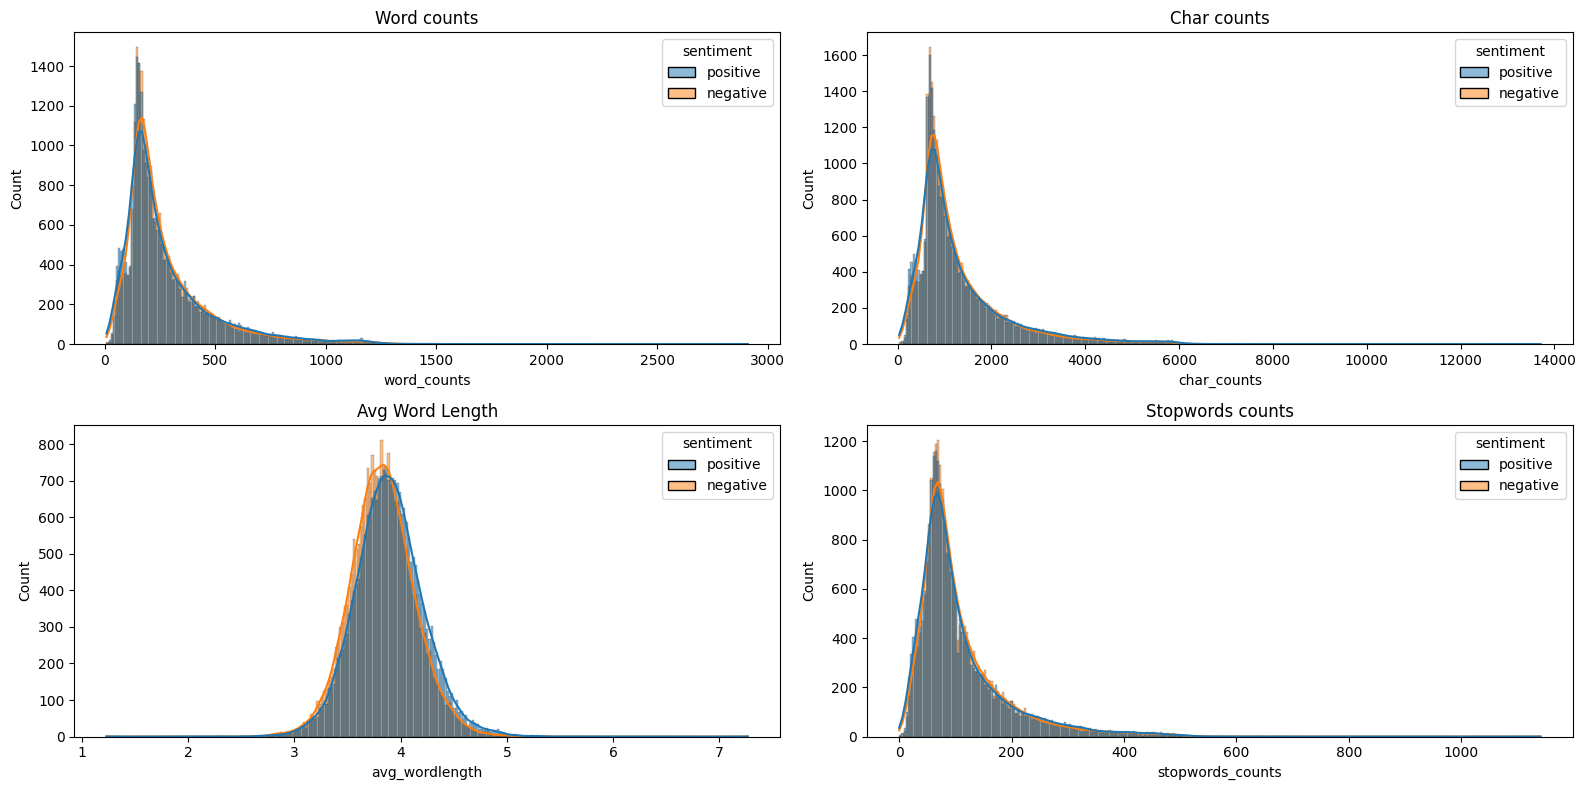

<ipython-input-8-c70f6820dba2>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')


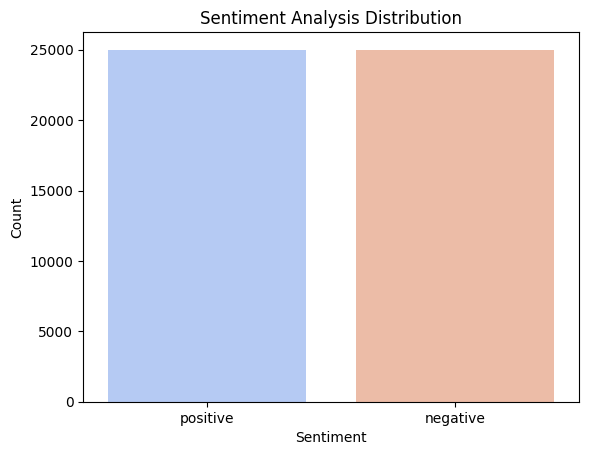

In [ ]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
sns.histplot(data=df, x='word_counts', hue='sentiment', kde=True)
plt.title('Word counts')

plt.subplot(2, 2, 2)
sns.histplot(data=df, x='char_counts', hue='sentiment', kde=True)
plt.title('Char counts')

plt.subplot(2, 2, 3)
sns.histplot(data=df, x='avg_wordlength', hue='sentiment', kde=True)
plt.title('Avg Word Length')

plt.subplot(2, 2, 4)
sns.histplot(data=df, x='stopwords_counts', hue='sentiment', kde=True)
plt.title('Stopwords counts')

plt.tight_layout()
plt.show()

# Sentiment Distribution
sentiment_counts = df['sentiment'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')
plt.title("Sentiment Analysis Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


6. Keyword Extraction (TF-IDF & RAKE) and Visualizing Keyword Extraction:

In [10]:
def extract_keywords_tfidf(corpus, n=10):
    vectorizer = TfidfVectorizer(max_df=0.85, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()

    keywords = []
    for i, row in enumerate(tfidf_matrix):
        row_data = row.toarray().flatten()
        top_indices = row_data.argsort()[-n:][::-1]  # Get indices of top keywords
        top_keywords = [feature_names[index] for index in top_indices]
        keywords.append(top_keywords)
    return keywords

df['tfidf_keywords'] = extract_keywords_tfidf(df['review_without_stopwords'])

In [11]:
# RAKE Approach for Keyword Extraction
rake = Rake()  # Using stopwords from NLTK, punctuation is automatically removed
def extract_keywords_rake(text):
    rake.extract_keywords_from_text(text)
    return rake.get_ranked_phrases()[:10]  # Get top 10 phrases

df['rake_keywords'] = df['review_without_stopwords'].apply(extract_keywords_rake)

In [13]:
df[['review', 'tfidf_keywords', 'rake_keywords', ]].head()

,review,tfidf_keywords,rake_keywords
0,one of the other reviewers has mentioned that ...,"[oz, violence, prison, inmates, forget, struck...",[middle class inmates turned prison bitches du...
1,a wonderful little production. the filming tec...,"[halliwell, polari, realism, murals, terrificl...","[michael sheen `` got polari '' voices pat, tr..."
2,i thought this was a wonderful way to spend ti...,"[woody, johanson, wittier, prada, conditioned,...",[wittier `` devil wears prada '' interesting `...
3,basically there's a family where a little boy ...,"[jake, parents, closet, drama, zombie, divorci...","[going make film must decide thriller drama, i..."
4,"petter mattei's ""love in the time of money"" is...","[mattei, relations, mr, encounter, petter, dis...",[director transfers action present time new yo...


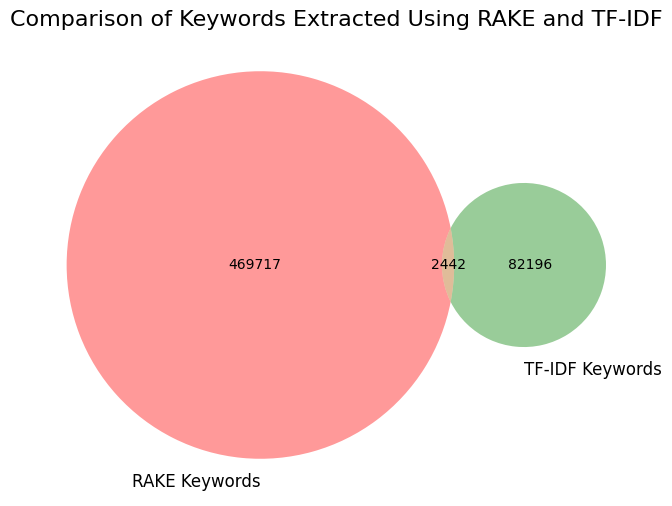

In [14]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Extract keywords from RAKE and TF-IDF
rake_keywords = df['rake_keywords'].explode().unique()
tfidf_keywords = df['tfidf_keywords'].explode().unique()

# Create a Venn diagram
plt.figure(figsize=(8, 6))
venn2([set(rake_keywords), set(tfidf_keywords)], ('RAKE Keywords', 'TF-IDF Keywords'))
plt.title("Comparison of Keywords Extracted Using RAKE and TF-IDF", fontsize=16)
plt.show()

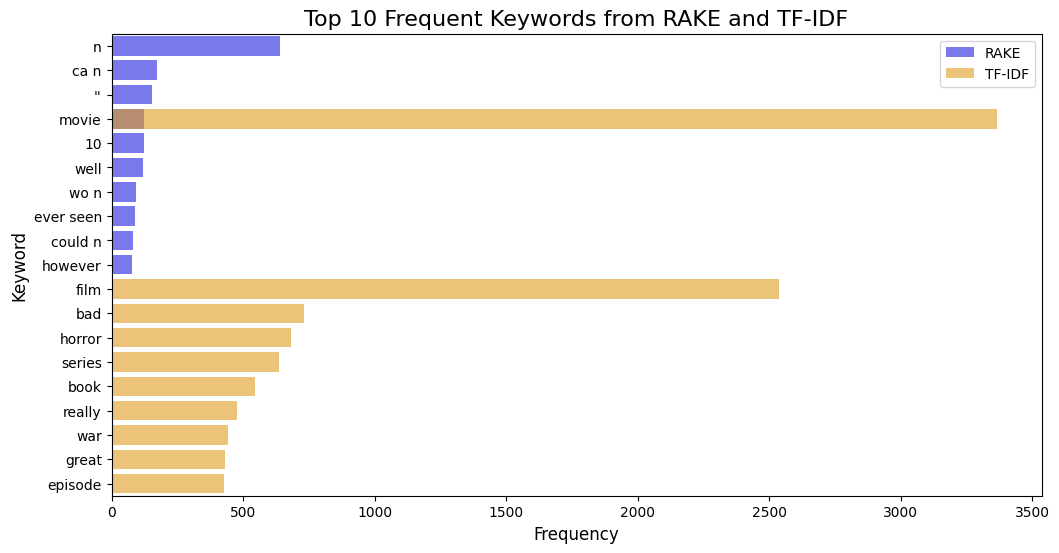

In [15]:
from collections import Counter

# Flatten the lists of keywords and count their frequencies
rake_keywords_flat = df['rake_keywords'].explode().dropna()
tfidf_keywords_flat = df['tfidf_keywords'].explode().dropna()

rake_counts = Counter(rake_keywords_flat)
tfidf_counts = Counter(tfidf_keywords_flat)

# Convert to DataFrames for easier plotting
rake_df = pd.DataFrame(rake_counts.items(), columns=['Keyword', 'Frequency']).sort_values(by='Frequency', ascending=False).head(10)
tfidf_df = pd.DataFrame(tfidf_counts.items(), columns=['Keyword', 'Frequency']).sort_values(by='Frequency', ascending=False).head(10)

# Create a bar plot for RAKE keywords
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Keyword', data=rake_df, color='blue', alpha=0.6, label='RAKE')
sns.barplot(x='Frequency', y='Keyword', data=tfidf_df, color='orange', alpha=0.6, label='TF-IDF')

# Add titles and labels
plt.title("Top 10 Frequent Keywords from RAKE and TF-IDF", fontsize=16)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Keyword", fontsize=12)
plt.legend()
plt.show()


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=50)

# Apply TF-IDF on cleaned reviews
tfidf_matrix = tfidf.fit_transform(df['review_without_stopwords'])

# Get feature names (keywords)
keywords = tfidf.get_feature_names_out()

feature_names = tfidf.get_feature_names_out()
tfidf_scores = tfidf.idf_

# Create a dictionary of keywords and their TF-IDF scores
keyword_scores = dict(zip(feature_names, tfidf_scores))

print("Keyword Scores:", keyword_scores)


Keyword Scores: {'10': 3.0091894884945067, 'acting': 2.5424536834536293, 'actors': 2.9296631763914442, 'actually': 2.9860440607918908, 'bad': 2.4450457759837163, 'best': 2.643014695762946, 'better': 2.687311351438967, 'character': 2.655292448577902, 'characters': 2.5852532235372854, 'director': 2.9661328561728353, 'end': 2.726441267719922, 'film': 1.588446869589545, 'films': 2.6979613108255065, 'funny': 3.0599726888959915, 'going': 2.9999851479780606, 'good': 1.967551395867754, 'great': 2.3804913476171046, 'know': 2.6411549989773575, 'life': 2.707842814155504, 'like': 1.7695731755625739, 'little': 2.666981098477769, 'look': 2.988086366388708, 'lot': 3.026944995569593, 'love': 2.7234107923101343, 'make': 2.4080692927229226, 'makes': 2.966704448071793, 'man': 2.8327264713614637, 'movie': 1.4922528782086795, 'movies': 2.537974810612239, 'new': 3.098032927065274, 'old': 3.00680605224032, 'people': 2.402199870150117, 'plot': 2.6139680677119888, 'real': 2.9128629451511205, 'really': 2.200864

In [18]:
# Convert the dictionary to a Pandas DataFrame for sorting
import pandas as pd
keyword_df = pd.DataFrame(list(keyword_scores.items()), columns=['Keyword', 'TF-IDF Score'])

# Sort the DataFrame by TF-IDF score in descending order
sorted_keywords = keyword_df.sort_values(by='TF-IDF Score', ascending=False)

print(sorted_keywords.head())

   Keyword  TF-IDF Score
48   world      3.187492
29     new      3.098033
13   funny      3.059973
22     lot      3.026945
0       10      3.009189


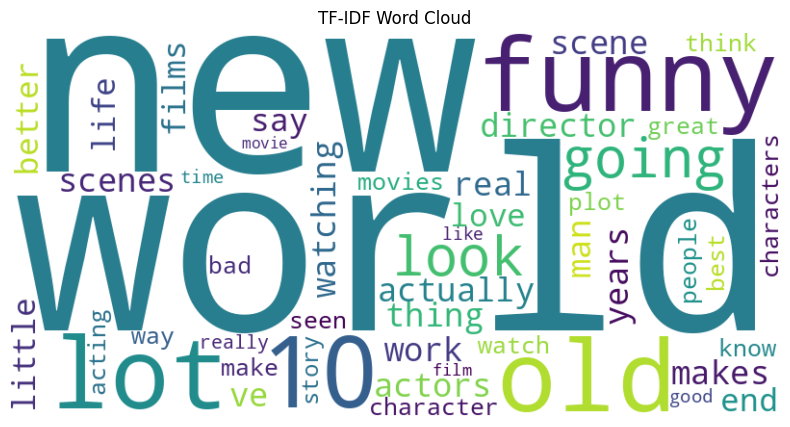

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate a word cloud using the TF-IDF scores
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_scores)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.title('TF-IDF Word Cloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.show()

7. Building and Training Classification Models:


In [23]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=0, stratify=df['sentiment'])



In [24]:
# Build SVM classifier pipeline
clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])


In [29]:
# Random Forest Classifier Pipeline
rf_clf = Pipeline([('tfidf', TfidfVectorizer()),('clf', RandomForestClassifier(n_estimators=100, random_state=42))])

In [30]:
# Train the Random Forest model
rf_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier(random_state=42))])

In [31]:
# Train the SVM classifier
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [32]:
# Predict and evaluate_SVM
y_pred = clf.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred))

SVM Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.89      0.90      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [33]:
# Predictions
y_pred_rf = rf_clf.predict(X_test)

# Evaluation Report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.84      0.84      5000
    positive       0.84      0.84      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



SVM confusion matrix :


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

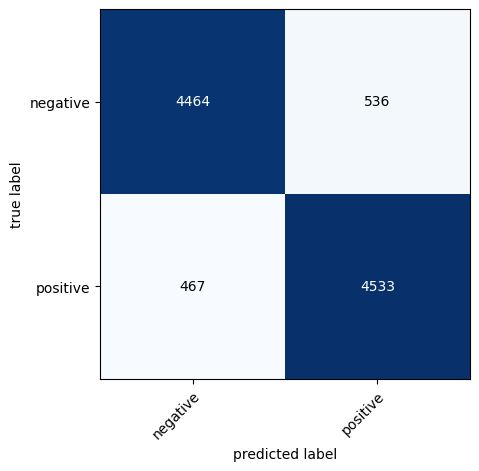

In [35]:
# Confusion matrix for SVM
print("SVM confusion matrix :")
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_names=clf.classes_)

Random Forest confusion matrix :


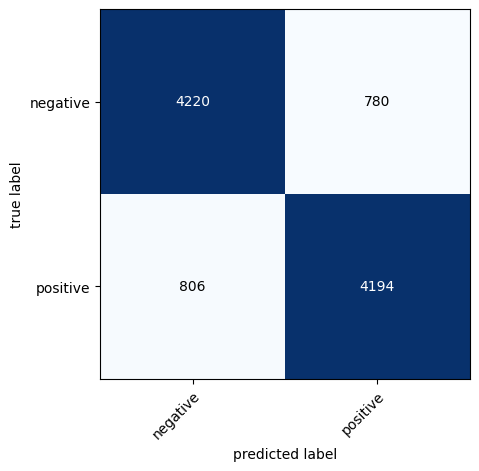

In [36]:
# Confusion Matrix for Random Forest
print("Random Forest confusion matrix :")
cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf, class_names=rf_clf.classes_)
plt.show()

In [37]:
# Test SVM with sample reviews
print("SVM Predictions")
print(clf.predict(['Wow, this is amazing lesson']))
print(clf.predict(['Wow, this sucks']))

SVM Predictions
['positive']
['negative']


In [38]:
# Test Random Forest model on sample inputs
print("Random forest Predictions")
print(rf_clf.predict(['Wow, this is an amazing lesson']))
print(rf_clf.predict(['Wow, this sucks']))

Random forest Predictions
['positive']
['negative']


Saving Models as pickle files

In [39]:
import pickle
# Save the model as a pickle file
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(clf, file)